In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [24]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from thc_net.explainable_model.input_utils import preproc_dataset
from thc_net.explainable_model.model import build_model
from thc_net.explainable_model.random_utils import setup_seed

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [6]:
dataset_name = "bank-marketing"
filename = "train_bench.csv"
target = "y"
ids = []

<IPython.core.display.Javascript object>

dataset_name = "census-income"
filename = "train_bench.csv"
target = "taxable income amount"
ids = []

dataset_name = "rl"
filename = "train_bench.csv"
target = "target"
ids = []

In [7]:
out = Path(os.getcwd()) / "data" / dataset_name / filename

<IPython.core.display.Javascript object>

In [8]:
train = pd.read_csv(out)
train.shape

(41188, 21)

<IPython.core.display.Javascript object>

In [9]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

<IPython.core.display.Javascript object>

In [10]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [11]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ids + ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['contact'],
 'num_cols': ['euribor3m',
  'nr_employed',
  'pdays',
  'age',
  'previous',
  'campaign',
  'emp_var_rate',
  'cons_conf_idx',
  'cons_price_idx'],
 'cat_cols': ['loan',
  'month',
  'default',
  'day_of_week',
  'housing',
  'job',
  'education',
  'poutcome',
  'marital'],
 'num_encoder': [SimpleImputer(fill_value=0.460393384648371, strategy='constant'),
  SimpleImputer(fill_value=4956.36064204546, strategy='constant'),
  SimpleImputer(fill_value=-18.72055347235185, strategy='constant'),
  SimpleImputer(fill_value=15.955021681255555, strategy='constant'),
  SimpleImputer(fill_value=-0.0495943770348874, strategy='constant'),
  SimpleImputer(fill_value=0.7241611217453983, strategy='constant'),
  SimpleImputer(fill_value=-3.557134365384693, strategy='constant'),
  SimpleImputer(fill_value=-51.26324405539975, strategy='constant'),
  SimpleImputer(fill_value=92.14308060910383, strategy='constant')],
 'bool_encoder': [SafeLabelEncoder()],


<IPython.core.display.Javascript object>

In [12]:
input_valid, _ = preproc_dataset(
    train.loc[valid_indices], target, ids + ["Set"], params
)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ids + ["Set"], params)

<IPython.core.display.Javascript object>

In [13]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [14]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [15]:
model = build_model(params, lconv_dim=[64, 32], lconv_num_dim=[16],)

<IPython.core.display.Javascript object>

In [61]:
model.get_layer("output")._build_input_shape

TensorShape([None, 433])

<IPython.core.display.Javascript object>

In [16]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 9, 19)]      0                                            
__________________________________________________________________________________________________
block_cat_0_conv (LocallyConnec (None, 9, 64)        10944       input_cat[0][0]                  
__________________________________________________________________________________________________
block_cat_0_nb (BatchNormalizat (None, 9, 64)        256         block_cat_0_conv[0][0]           
__________________________________________________________________________________________________
input_num (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [17]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

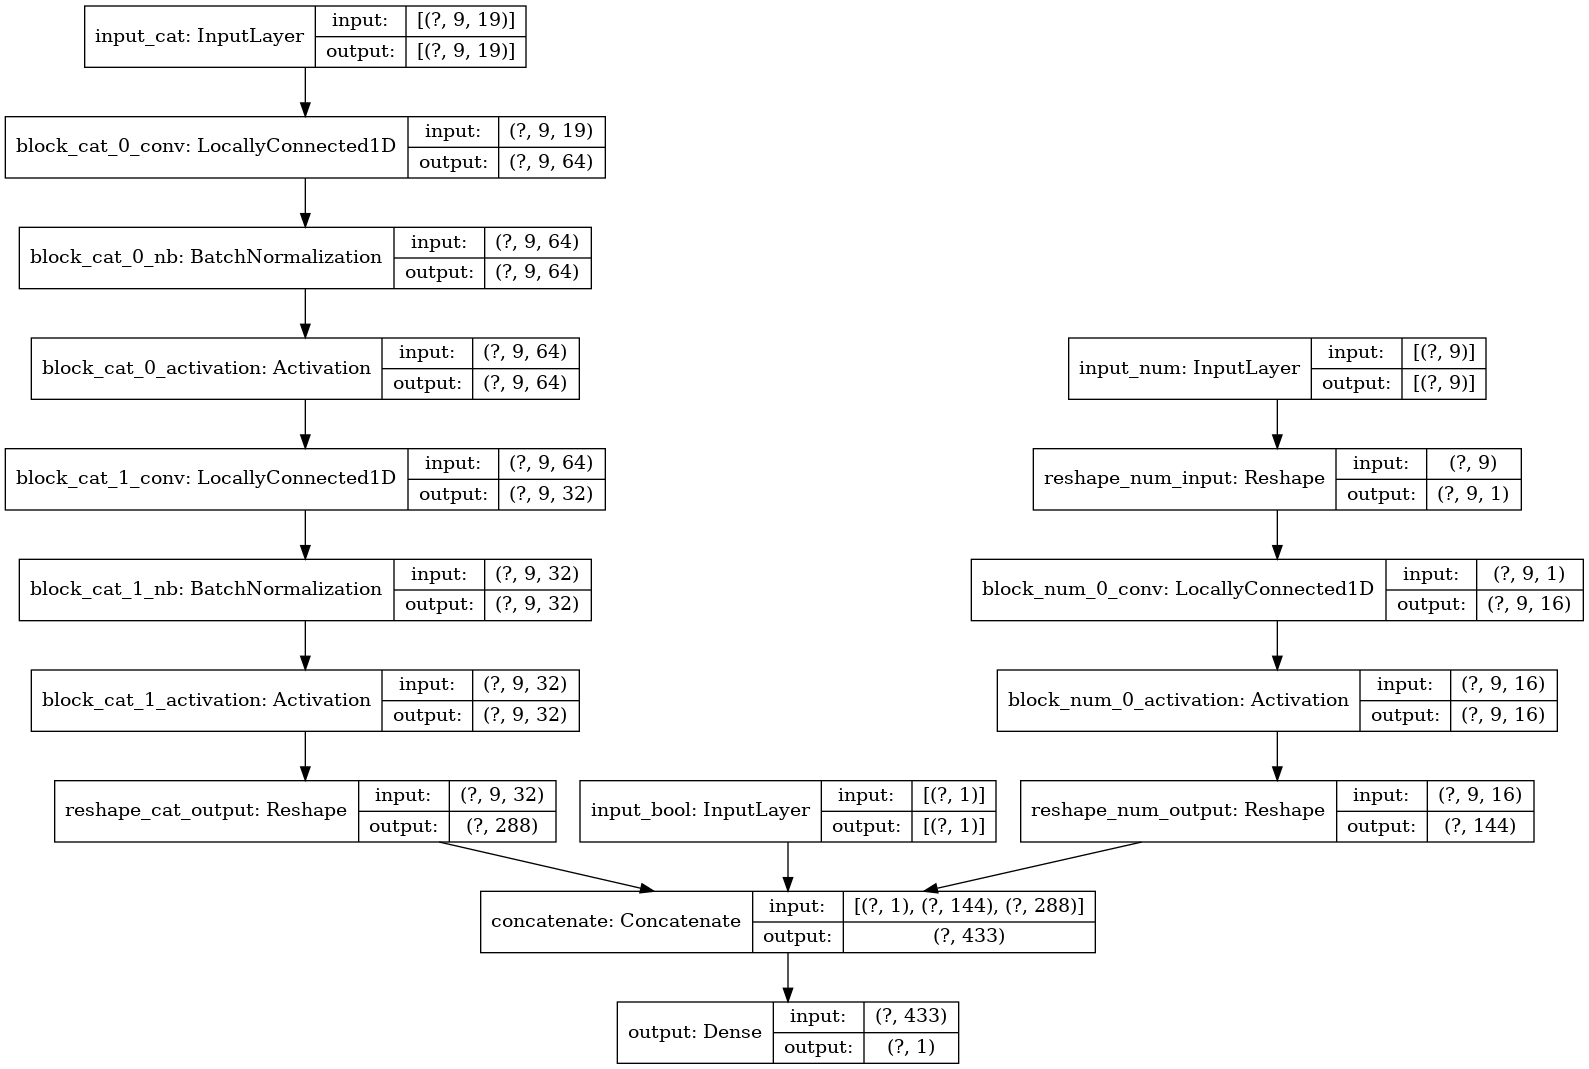

<IPython.core.display.Javascript object>

In [20]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [21]:
y_train.shape

(32950,)

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
)

Epoch 1/2000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


33/33 [==============================] - 5s 141ms/step - loss: 0.4745 - val_loss: 0.3908
Epoch 2/2000
33/33 [==============================] - 5s 140ms/step - loss: 0.3339 - val_loss: 0.3779
Epoch 3/2000
33/33 [==============================] - 4s 129ms/step - loss: 0.3297 - val_loss: 0.3774
Epoch 4/2000
33/33 [==============================] - 4s 107ms/step - loss: 0.3268 - val_loss: 0.3695
Epoch 5/2000
33/33 [==============================] - 4s 114ms/step - loss: 0.3244 - val_loss: 0.3628
Epoch 6/2000
33/33 [==============================] - 4s 113ms/step - loss: 0.3219 - val_loss: 0.3563
Epoch 7/2000
33/33 [==============================] - 4s 119ms/step - loss: 0.3192 - val_loss: 0.3505
Epoch 8/2000
33/33 [==============================] - 3s 102ms/step - loss: 0.3164 - val_loss: 0.3442
Epoch 9/2000
33/33 [==============================] - 3s 99ms/step - loss: 0.3135 - val_loss: 0.3398
Epoch 10/2000
33/33 [==============================] - 4s 128ms/step - loss: 0.3101 - val_loss: 

Epoch 81/2000
33/33 [==============================] - 5s 148ms/step - loss: 0.2845 - val_loss: 0.2979
Epoch 82/2000
33/33 [==============================] - 4s 131ms/step - loss: 0.2837 - val_loss: 0.2909
Epoch 83/2000
33/33 [==============================] - 4s 126ms/step - loss: 0.2840 - val_loss: 0.2985
Epoch 84/2000
33/33 [==============================] - 4s 110ms/step - loss: 0.2843 - val_loss: 0.2908
Epoch 85/2000
33/33 [==============================] - 3s 105ms/step - loss: 0.2843 - val_loss: 0.2918
Epoch 86/2000
33/33 [==============================] - 3s 102ms/step - loss: 0.2838 - val_loss: 0.2910
Epoch 87/2000
33/33 [==============================] - 4s 121ms/step - loss: 0.2844 - val_loss: 0.2965
Epoch 88/2000
33/33 [==============================] - 4s 113ms/step - loss: 0.2846 - val_loss: 0.2901
Epoch 89/2000
33/33 [==============================] - 4s 111ms/step - loss: 0.2839 - val_loss: 0.2937
Epoch 90/2000
33/33 [==============================] - 4s 115ms/step - lo

<IPython.core.display.Javascript object>

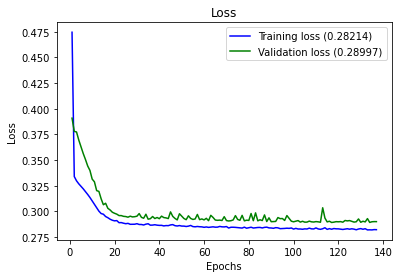

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(input_valid).reshape(-1),
)
model_auc

0.7812210336949205

<IPython.core.display.Javascript object>

In [28]:
# BM : 0.7847761386793823
# Census : 0.9461137700867462
# give me some credit : 0.8584216818313924

<IPython.core.display.Javascript object>

In [29]:
model_auc = roc_auc_score(y_true=y_test, y_score=model.predict(input_test).reshape(-1),)
model_auc

0.8076055545313701

<IPython.core.display.Javascript object>

In [64]:
model.get_layer("reshape_num_input").output_shape[1]

9

<IPython.core.display.Javascript object>

In [66]:
model.has_layer("aze")

AttributeError: 'Model' object has no attribute 'has_layer'

<IPython.core.display.Javascript object>

In [ ]:
#  BM : 0.8091600443913225
# Census : 0.9467201048401863
# give me some credit : 0.8599316528022821

In [ ]:
# New version V3 => number are fillna, and activation is tanh instead of mish


In [ ]:
# NEW VERSION
# Bank marketing
# valid 0.7974101623084582 test 0.8133980360868731     conv_dim=[],    lconv_dim=[128, 64, 32],    lconv_num_dim=[64, 32, 16], patience 20
# RL
# valid 0.9334586431074957 test 0.9331843177543191     conv_dim=[],    lconv_dim=[128, 64, 32],    lconv_num_dim=[64, 32, 16], patience 20

In [ ]:
# Census example
# valid 0.9282381974389771 test 0.9262939626480025 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# RL
# valid 0.9363136991351992 test 0.9431532242454923 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# Open payments
# valid 0.9395366568006073 test 0.9370193221838594 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

# give-me-some-credit
# valid  test  conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

In [ ]:
SAMPLE_NB = 1000

In [ ]:
if INPUT_DIM > 0:
    sample = X_valid_preproc[:SAMPLE_NB]
if INPUT_DIM_BOOL > 0:
    bool_sample = X_bool_valid[:SAMPLE_NB]
if INPUT_DIM_NUM > 0:
    num_sample = X_num_valid[:SAMPLE_NB]
input_sample = []

In [ ]:
if INPUT_DIM_BOOL > 0:
    input_sample.append(bool_sample)
if INPUT_DIM_NUM > 0:
    input_sample.append(num_sample)
if INPUT_DIM > 0:
    input_sample.append(sample)


In [ ]:
model_pred = model.predict(input_sample)
model_pred.shape

In [ ]:
model.layers[-2].output

In [ ]:
model.layers[-3].output

In [ ]:
new_model = Model(
    inputs=[model.inputs],
    outputs=[model.output, model.layers[-2].output, model.layers[-3].output],
)

In [ ]:
new_model_pred, feature_cat_inter, feature_num_inter = new_model.predict(input_sample)

In [ ]:
assert np.all(model_pred == new_model_pred)

In [ ]:
feature_cat_inter.shape

In [ ]:
feature_num_inter.shape

In [ ]:
# feature_inter.shape

In [ ]:
new_model.layers[-1]

In [ ]:
model.get_weights()[-2].shape

In [ ]:
model.layers[-2].output

In [ ]:
new_model = Model(inputs=[model.input], outputs=[model.layers[-2].output])

In [ ]:
%%time
new_train_logistic = new_model.predict(input_model)
new_valid_logistic = new_model.predict(input_valid)
new_test_logistic = new_model.predict(input_test)


In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
lreg = LogisticRegression(max_iter=300, n_jobs=-1, random_state=SEED)

In [ ]:
%%time
lreg.fit(new_train_logistic, y_train.reshape(-1))

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=lreg.predict_proba(new_valid_logistic)[:, 1],
)

In [ ]:
#  BM : 0.7914463179718816
# give me some credit :0.8582349903898445

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=lreg.predict_proba(new_test_logistic)[:, 1],
)

In [ ]:
# BM : 0.8097976507760546
# give me some credit :0.8593843699840211


roc_auc_score(
    y_true=y_test, y_score=lreg_cv.predict_proba(new_test_logistic)[:, 1],
)

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(verbosity=1, tree_method="hist", seed=SEED,)

In [ ]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

In [ ]:
new_train_logistic.shape

In [ ]:
cat_cols = {}

In [ ]:
for col in used_columns:
    enc = LabelEncoder()
    train[col] = enc.fit_transform(train[col].values.astype("str").reshape(-1))
    cat_cols[col] = enc

In [ ]:
new_concat_train = np.hstack(
    [
        new_train_logistic,
        train[num_cols].values[train_indices],
        train[used_columns].values[train_indices],
    ]
)
new_concat_train.shape

In [ ]:
new_concat_valid = np.hstack(
    [
        new_valid_logistic,
        train[num_cols].values[valid_indices],
        train[used_columns].values[valid_indices],
    ]
)
new_concat_valid.shape

In [ ]:
new_concat_test = np.hstack(
    [
        new_test_logistic,
        train[num_cols].values[test_indices],
        train[used_columns].values[test_indices],
    ]
)
new_concat_test.shape

In [ ]:
xgb.fit(
    new_concat_train,
    y_train.reshape(-1),
    eval_set=[(new_concat_valid, y_valid.reshape(-1))],
    eval_metric="auc",
    early_stopping_rounds=20,
)

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=xgb.predict_proba(new_concat_valid)[:, 1],
)

In [ ]:
#  BM : 0.7950377112004379
# give me some credit :0.8608505974744193


In [ ]:
roc_auc_score(
    y_true=y_test, y_score=xgb.predict_proba(new_concat_test)[:, 1],
)

In [ ]:
#  BM : 0.8175536181491652
# give me some credit :0.8636238967612501

In [ ]:
stack_valid = (
    lreg.predict_proba(new_valid_logistic)[:, 1].reshape(-1)
    + xgb.predict_proba(new_concat_valid)[:, 1].reshape(-1)
    # + model.predict(input_valid).reshape(-1)
) / 2
stack_valid.shape

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=stack_valid,
)

In [ ]:
# BM 0.7989376973709024
# give me some credit :0.8620617468400065

In [ ]:
stack_test = (
    lreg.predict_proba(new_test_logistic)[:, 1].reshape(-1)
    + xgb.predict_proba(new_concat_test)[:, 1].reshape(-1)
    # + model.predict(input_test).reshape(-1)
) / 2
stack_test.shape

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=stack_test,
)

In [ ]:
# BM 0.8212055857859865
# give me some credit :0.8640850442432623

In [ ]:
lreg.coef_

In [ ]:
model.get_weights()[-2]

In [ ]:
explainable_model = Model(
    inputs=[model.input], outputs=[model.output, model.layers[-3].output]
)

In [ ]:
preds, explainability = explainable_model.predict(input_sample)

In [ ]:
preds.shape

In [ ]:
explainability.shape

In [ ]:
model.get_weights()[-6].shape

In [ ]:
model.layers[-6].output

In [ ]:
model.layers[-7].output

In [ ]:
model.layers[-5]

In [ ]:
explainable_model = Model(
    inputs=[model.input],
    outputs=[
        model.output,
        model.layers[-5].output,
        model.layers[-7].output,
        model.layers[-6].output,
    ],
)

In [ ]:
preds, expl_boo, expl_num, expl_others = explainable_model.predict(input_sample)

In [ ]:
expl_num.shape

In [ ]:
preds

In [ ]:
model.get_weights()[-2].shape

In [ ]:
bool_weight = model.get_weights()[-2][:1]
bool_weight.shape

In [ ]:
num_weight = model.get_weights()[-2][1 : 9 * 16 + 1].reshape(-1, 16)
num_weight.shape

In [ ]:
others_weight = model.get_weights()[-2][9 * 16 + 1 :].reshape(-1, 32)
others_weight.shape

In [ ]:
expl_boo[0]

In [ ]:
expl_num[0].shape

In [ ]:
expl_others[0].shape

In [ ]:
1 + 9 * 16 + 9 * 32

In [ ]:
manual_pred = (
    expl_boo[0].reshape(-1) * bool_weight.reshape(-1)
    + (expl_num[0].reshape(-1) * num_weight.reshape(-1)).sum()
    + (expl_others[0].reshape(-1) * others_weight.reshape(-1)).sum()
) + model.layers[-1].get_weights()[1]
manual_pred

In [ ]:
from tensorflow.keras.activations import sigmoid

In [ ]:
assert np.isclose(sigmoid(manual_pred).numpy(), preds[0])

In [ ]:
model.layers[-1].get_weights()[1]

In [ ]:
all(model.get_weights()[-2] == model.layers[-1].get_weights()[0])

In [ ]:
expl_num[0].shape

In [ ]:
num_weight.shape

In [ ]:
features_explain = np.hstack(
    [
        (expl_boo * bool_weight).sum(axis=-1).reshape(-1, 1),
        (expl_num * num_weight).sum(-1),
        (expl_others * others_weight).sum(axis=-1),
    ]
)
features_explain.shape

In [ ]:
np.allclose(
    sigmoid(features_explain.sum(axis=1) + model.layers[-1].get_weights()[1]).numpy(),
    preds.reshape(-1),
)

In [ ]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    # objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
    y_pos = np.arange(importances.shape[0])
    indexes = np.argsort(importances)
    performance = importances[indexes]

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[indexes])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

In [ ]:
all_cols = np.array(bool_cols + num_cols.tolist() + used_columns)
all_cols

In [ ]:
explain_plot(np.abs(features_explain).sum(axis=0), all_cols)

In [ ]:
explain_plot(features_explain.sum(axis=0), all_cols)

In [ ]:
explain_plot(features_explain[10], all_cols)

In [ ]:
explain_plot(features_explain[0], all_cols)

In [ ]:
def sigmoid_derivate(x):
    return np.exp(-x) / (np.exp(-x) + 1) ** 2

In [ ]:
sigmoid_derivate(features_explain[10]).sum()

In [ ]:
sigmoid(features_explain[10])

In [ ]:
features_explain[0]

In [ ]:
explain_plot(features_explain[0], all_cols)

In [ ]:
for explanation in features_explain[:10]:
    explain_plot(explanation, all_cols)